## SETUP

In [1]:
!pip install "tensorflow-text==2.8.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 7.6 MB/s 


In [2]:
import numpy as np
import typing
from typing import Any, Tuple
import tensorflow as tf
import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
### shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## DATASET

After downloading the dataset, here are the steps you need to take to prepare the data:

1.   Add a start and end token to each sentence.

2.   Clean the sentences by removing special characters.
3.   Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [4]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

2654208/2638744 [==============================] - 0s 0us/step


In [5]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

targ, inp = load_data(path_to_file)
print(inp[-1])
print(targ[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [6]:
### create tf.data DATASET
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'\xc3\x89l record\xc3\xb3 a su mujer que le ten\xc3\xada que despertar a las siete de la ma\xc3\xb1ana.'
 b'No te preocupes, no estoy enfadado contigo.'
 b'Los ni\xc3\xb1os corrieron a la sala.' b'\xc2\xbfSabes usarlo?'
 b'Tom le dio apoyo moral a Mary.'], shape=(5,), dtype=string)

tf.Tensor(
[b'He reminded his wife to wake him up at 7:00 a.m.'
 b"Don't worry. I'm not mad at you."
 b'The children ran toward the classroom.' b'Do you know how to use it?'
 b'Tom gave Mary moral support.'], shape=(5,), dtype=string)


## TEXT PREPROCESSING

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

In [7]:
# The first step is Unicode normalization to 
# split accented characters and replace compatibility characters 
# with their ASCII equivalents.

def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

example_text = tf.constant('¿Todavía está en casa?')
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [8]:
# Text Vectorization
# This standardization function will be wrapped up in a tf.keras.layers.TextVectorization layer 
# which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

# The TextVectorization layer and many other Keras preprocessing layers have an adapt method. 
# This method reads one epoch of the training data, and works a lot like Model.fit. 
# This adapt method initializes the layer based on the data. 
# Here it determines the vocabulary:

#inp is the corpus with spanish phrases
input_text_processor.adapt(inp)



# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [9]:
# build the same for english
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [10]:
## these layers can convert a batch of strings into a batch of token IDs

#example_input_batch is a list of strings

example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,    7, 3535,    8,   25,  292,    5,   28,  134,    5],
       [   2,    9,   30, 1456,   19,    9,   41, 1042,  245,    4],
       [   2,   26,  189,    1,    8,   11,  802,    4,    3,    0]])>

In [11]:
# The get_vocabulary method can be used to convert token IDs back to text:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] el recordo a su mujer que le tenia que despertar a las siete de la manana . [END]'

In [12]:
print(example_tokens)

tf.Tensor(
[[   2    7 3535 ...   84    4    3]
 [   2    9   30 ...    0    0    0]
 [   2   26  189 ...    0    0    0]
 ...
 [   2   62   48 ...    0    0    0]
 [   2   13   71 ...    0    0    0]
 [   2   28 1647 ...    0    0    0]], shape=(64, 19), dtype=int64)


## ENCODER/DECODER MODEL

In [13]:
embedding_dim = 256
units = 1024

The encoder:

1. Takes a list of token IDs (from input_text_processor).
2. Looks up an embedding vector for each token (Using a layers.Embedding).
3. Processes the embeddings into a new sequence (Using a layers.GRU).
4. Returns:
  * The processed sequence. This will be passed to the attention head.
  * The internal state. This will be used to initialize the decoder




In [14]:
# The encoder returns its internal state 
# so that its state can be used to initialize the decoder.

class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

The attention head

The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example.

In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights
  
attention_layer = BahdanauAttention(units)

The decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

In [16]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [17]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

  def call(self,
        inputs: DecoderInput,
        state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))

    if state is not None:
      shape_checker(state, ('batch', 'dec_units'))

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))

    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

## TRAINING

Loss Function

In [18]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

Implement the training step

In [19]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor,
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

  def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))

    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask

  def _train_step(self, inputs):
    input_text, target_text = inputs

    (input_tokens, input_mask,
    target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
      # Encode the input
      enc_output, enc_state = self.encoder(input_tokens)
      self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
      self.shape_checker(enc_state, ('batch', 'enc_units'))

      # Initialize the decoder's state to the encoder's final state.
      # This only works if the encoder and decoder have the same number of
      # units.
      dec_state = enc_state
      loss = tf.constant(0.0)

      for t in tf.range(max_target_length-1):
        # Pass in two tokens from the target sequence:
        # 1. The current input to the decoder.
        # 2. The target for the decoder's next prediction.
        new_tokens = target_tokens[:, t:t+2]
        step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                              enc_output, dec_state)
        loss = loss + step_loss

      # Average the loss over all non padding tokens.
      average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

  def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                  enc_output=enc_output,
                                  mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))

    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

  @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]), tf.TensorSpec(dtype=tf.string, shape=[None])]])
  def _tf_train_step(self, inputs):
    return self._train_step(inputs)

Test training step

In [20]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [21]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5919304>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5599036>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.4970994>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.302761>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.5342503>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.658829>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.6373014>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1465793>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.927702>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9093168>}

CPU times: user 7.93 s, sys: 356 ms, total: 8.29 s
Wall time: 9.44 s


Actual train

In [22]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)
train_translator.use_tf_function = True

In [23]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [24]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
1859/1859 [==============================] - 580s 308ms/step - batch_loss: 2.0408
Epoch 2/3
1859/1859 [==============================] - 525s 282ms/step - batch_loss: 1.0368
Epoch 3/3
1859/1859 [==============================] - 504s 271ms/step - batch_loss: 0.8073


Text(0, 0.5, 'CE/token')

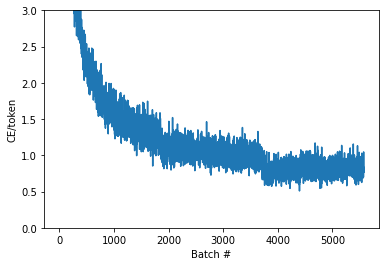

In [25]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

## TRANSLATE

Implement the translation loop

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using tf.concat to join them into tensors.

This implementation statically unrolls the graph out to max_length iterations. This is okay with eager execution in python.

In [30]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

  def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))

    result_text = tf.strings.reduce_join(result_text_tokens,
                                          axis=1, separator=' ')
    shape_checker(result_text, ('batch'))

    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text
  
  # This function takes the decoder's logit outputs and samples token IDs from that distribution:
  def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    # 't' is usually 1 here.
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
      new_tokens = tf.argmax(logits, axis=-1)
    else:
      logits = tf.squeeze(logits, axis=1)
      new_tokens = tf.random.categorical(logits/temperature,
                                          num_samples=1)

    shape_checker(new_tokens, ('batch', 't'))

    return new_tokens

  def translate(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
      dec_input = DecoderInput(new_tokens=new_tokens,
                              enc_output=enc_output,
                              mask=(input_tokens!=0))

      dec_result, dec_state = self.decoder(dec_input, state=dec_state)

      attention.append(dec_result.attention_weights)

      new_tokens = self.sample(dec_result.logits, temperature)

      # If a sequence produces an `end_token`, set it `done`
      done = done | (new_tokens == self.end_token)
      # Once a sequence is done it only produces 0-padding.
      new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

      # Collect the generated tokens
      result_tokens.append(new_tokens)

      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
      attention_stack = tf.concat(attention, axis=1)
      return {'text': result_text, 'attention': attention_stack}
    else:
      return {'text': result_text}

In [31]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [32]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

christmas is a long time ago .
this is my life .

CPU times: user 459 ms, sys: 9.84 ms, total: 469 ms
Wall time: 498 ms


## VISUALIZE THE PROCESS

The attention weights returned by the translate method show where the model was "looking" when it generated each output token.

[1.        0.9999999 1.        1.        1.        1.        1.0000001
 1.       ]


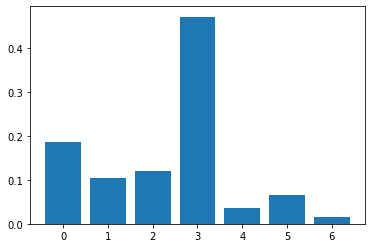

In [34]:
a = result['attention'][0]

print(np.sum(a, axis=-1))
_ = plt.bar(range(len(a[0, :])), a[0, :])

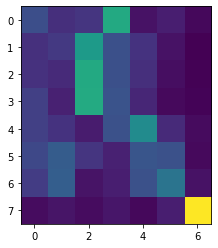

In [35]:
plt.imshow(np.array(a), vmin=0.0)

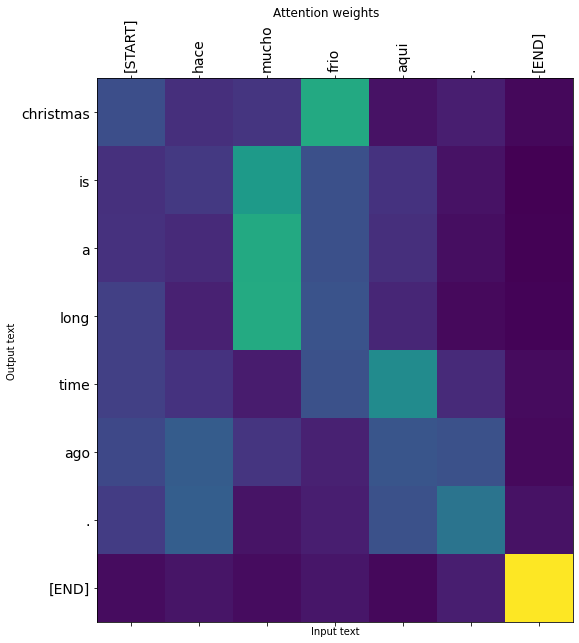

In [36]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])